<a href="https://www.kaggle.com/code/aarushsinghkushwaha/notebook6d0046f800?scriptVersionId=168682673" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install ultralytics -q
!pip install supervision -q
!pip install roboflow -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
jupyterlab 4.1.2 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.3 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
osmnx 1.9.1 requires shapely>=2.0, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is i

In [26]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from roboflow import Roboflow
import os
from ultralytics import YOLO
import supervision as sv
import numpy as np
import pandas as pd
import easyocr
reader = easyocr.Reader(['en'])

In [25]:
# Importing the Dataset from Roboflow

rf = Roboflow(api_key="USrvBrFicPHwM8yH4emA")
project = rf.workspace("aasiku").project("number-plate-detection-5cip8")
dataset = project.version(1).download("yolov8")


#Updating data.yaml
with open("/kaggle/working/Number-Plate-detection-1/data.yaml") as file:
  read = file.readlines()

# Updating the path of train,test,valid in data.yaml
with open("/kaggle/working/Number-Plate-detection-1/data.yaml",'w') as file:
  for x in read:
    if "test:" in x.split(" "):
      file.write(f"test: /kaggle/working/Number-Plate-detection-1/test/images\n")
    elif "train:" in x.split(" "):
      file.write(f"train: /kaggle/working/Number-Plate-detection-1/train/images\n")
    elif "val:" in x.split(" "):
      file.write(f"val: /kaggle/working/Number-Plate-detection-1/valid/images\n")
    else:
      file.write(x)

# Using yolo8 nano for training.
model = YOLO("yolov8n.pt")

# Run the line below only if no training data is available
# resultsPlateDetections = model.train(data='/kaggle/working/Number-Plate-detection-1/data.yaml', epochs=100,imgsz = 640)


# After last training the YOLO8n model the best results are saved in best.pt .Using it to get the most optimum weights and biases. 

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.34, to fix: `pip install ultralytics==8.0.196`


In [4]:
NumPlateModel = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")

In [9]:
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)

SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


In [13]:
test_folder = Path("/kaggle/working/Number-Plate-detection-1/test/images")
list_images = list(test_folder.glob("*.jpg")) #Saving path of all the test_images in list_images
list_images[5]
imageadd = list_images[5]

In [14]:
image = (ToNumPlate(cv2.imread(str(imageadd))))


0: 640x640 1 licence, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 370.4ms postprocess per image at shape (1, 3, 640, 640)


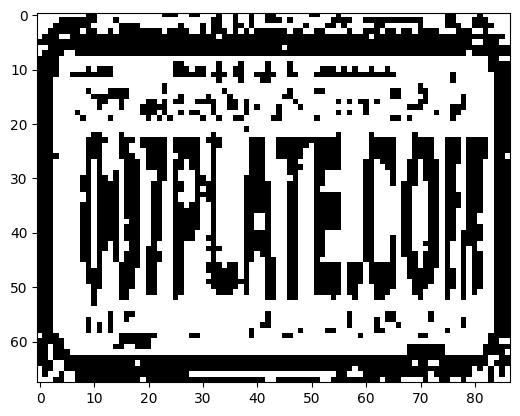

In [16]:
plt.imshow(adaptive_threshold,cmap = 'gray')

In [17]:
 results = pytesseract.image_to_string(adaptive_threshold)

In [18]:
Log = pd.DataFrame(columns = ["Tracker Id","Best Number Plate","NumPlateArr","Frequency"])

In [19]:
results

' \n\x0c'

In [20]:
# Impimenting CSV
def UpdateLog(df,trackerId,result,area):
    if result == "Not detected":
        area = 0
    size = df.shape[0]
    if trackerId in Log["Tracker Id"]:
        x = list(df["Tracker Id"] == trackerId).index(1)
        try:
            Log["NumPlateArr"][x][result] += area;
            if Log["NumPlateArr"][x][result]>Log["Frequency"][x]:
                Log["Frequency"][x] = Log["NumPlateArr"][x][result]
                Log["Best Number Plate"][x] = result
            
        except :
            Log["NumPlateArr"][x][result] = area
            Log["Best Number Plate"][x] = result
        return Log["Best Number Plate"][x]
    else:
        df.loc[size] = (trackerId,result,{result:area},area)
        return result
    
    
        

In [21]:
import pytesseract

In [27]:
# This function takes the image adress as input , runs the model through it , predicts the bounding box, and crops the image to show only the numplate based on the bounding box.
# Returns array corresponding to grayscaled numplate.
# If verbose ==1 , also shows how the numplate array looks,it is 0 by default.
def ToNumPlate(address):
    results = NumPlateModel(address)
    try:
        X,Y,x,y = list(results[0].boxes.xyxy.squeeze())
    
#     for result in results:
#         boxes = result.boxes
#         image = cv2.imread(str(address))
#         image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
#         try:
            
#             if verbose == 1:
#                 plt.imshow(image[int(Y):int(y),int(X):int(x)],cmap ='gray')
#         except:
#             a = (boxes.xyxy)

#             for k,t in enumerate(a):
#                 X,Y,x,y = list(t.squeeze())
#                 plt.subplot(len(list(a)),1,k+1)
#                 if verbose == 1:
#                     plt.imshow(image[int(Y):int(y),int(X):int(x)],cmap = 'gray')
        gray_image = cv2.cvtColor(address[int(Y):int(y),int(X):int(x)], cv2.COLOR_BGR2GRAY)
        adaptive_threshold = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        results = reader.readtext(adaptive_threshold)

        return results
    except :
        return "Not detected"


In [23]:
video = "/kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4"

In [21]:
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)

SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


requirements: Ultralytics requirement ['lapx>=0.5.2'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.7 MB/s eta 0:00:00a 0:00:01

requirements: AutoUpdate success ✅ 11.5s, installed 1 package: ['lapx>=0.5.2']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


video 1/1 (frame 1/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 1 motorcycle, 115.0ms

0: 384x640 (no detections), 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 52.6ms
Speed: 2.0ms preprocess, 52.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected
video 1/1 (frame 2/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 1 motorcycle, 7.0ms

0: 384x640 (no detections), 7.6ms
Speed:

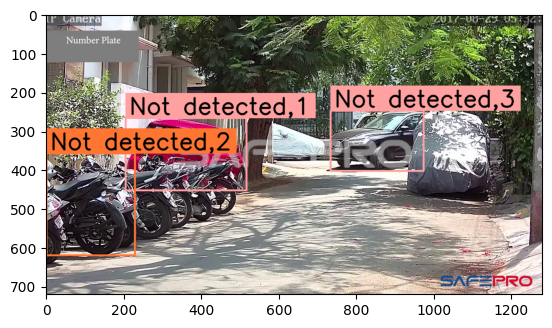

video 1/1 (frame 31/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 1 motorcycle, 7.6ms

0: 384x640 (no detections), 7.5ms
Speed: 1.5ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 448x640 (no detections), 6.9ms
Speed: 1.5ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)
Not detected
video 1/1 (frame 32/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 1 motorcycle, 7.1ms

0: 384x640 (no detections), 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.5ms
Speed: 2.6ms preprocess, 6.5ms inference, 0.5ms postpro

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x576 (no detections), 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 416x640 1 licence, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)
 

video 1/1 (frame 38/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 1 motorcycle, 7.9ms

0: 384x640 (no detections), 7.9ms
Speed: 1.4ms preprocess, 7.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.9ms
Speed: 2.7ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 416x640 1 licence, 6.9ms
Speed: 1.6ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)

video 1/1 (frame 39/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars,

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x576 (no detections), 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 416x640 1 licence, 6.7ms
Speed: 1.4ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)

video 1/1 (frame 40/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 1 motorcycle, 7.4ms

0: 384x640 (no detections), 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 416x640 1 licence, 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)

video 1/1 (frame 41/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 1

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

Not detected

0: 416x640 1 licence, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)

video 1/1 (frame 42/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 1 motorcycle, 8.0ms

0: 384x640 (no detections), 8.2ms
Speed: 1.4ms preprocess, 8.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 416x640 1 licence, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)
 

video 1/1 (frame 43/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 1 motorcycle, 7.4ms

0: 384x640 (no detections), 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 0.5ms postprocess per image at s

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x576 (no detections), 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 416x640 1 licence, 6.7ms
Speed: 1.6ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)
 

video 1/1 (frame 44/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 1 motorcycle, 7.6ms

0: 384x640 (no detections), 7.6ms
Speed: 1.4ms preprocess, 7.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 384x640 2 licences, 7.2ms
Speed: 1.4ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
Not detected
video 1/1 (frame 45/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x576 (no detections), 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 384x640 1 licence, 7.3ms
Speed: 1.3ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

video 1/1 (frame 48/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 1 motorcycle, 7.6ms

0: 384x640 (no detections), 7.0ms
Speed: 1.4ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 384x640 1 licence, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

video 1/1 (frame 49/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 1

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x576 (no detections), 7.7ms
Speed: 2.0ms preprocess, 7.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 384x640 1 licence, 7.2ms
Speed: 1.3ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

video 1/1 (frame 50/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 1 motorcycle, 7.9ms

0: 384x640 (no detections), 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 384x640 1 licence, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

video 1/1 (frame 51/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 1

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x576 (no detections), 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 384x640 (no detections), 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected
video 1/1 (frame 52/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 1 motorcycle, 7.7ms

0: 384x640 (no detections), 6.6ms
Speed: 1.2ms preprocess, 6.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 384x640 (no detections), 7.2ms
Speed: 1.3ms preprocess, 7.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected
video 1/1 (frame 53/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate 

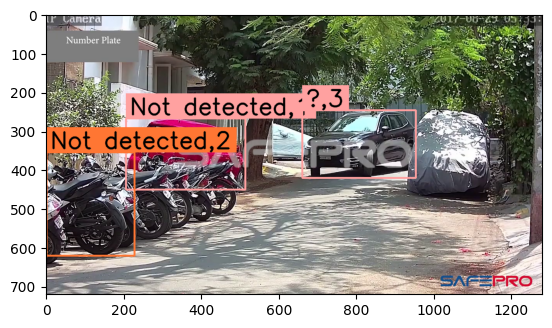

video 1/1 (frame 61/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 1 motorcycle, 9.4ms

0: 384x640 (no detections), 6.7ms
Speed: 1.4ms preprocess, 6.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x544 (no detections), 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 384x640 1 licence, 7.2ms
Speed: 1.5ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
 

video 1/1 (frame 62/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 1 motorcycle, 8.4ms

0: 384x640 (no detections), 7.6ms
Speed: 2.0ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 0.6ms postprocess per image 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

 

video 1/1 (frame 66/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 1 motorcycle, 7.9ms

0: 384x640 (no detections), 8.5ms
Speed: 1.4ms preprocess, 8.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 416x640 1 licence, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)
 

video 1/1 (frame 67/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 1 motorcycle, 8.3ms

0: 384x640 (no detections), 7.7ms
Speed: 1.3ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected



You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x576 (no detections), 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 416x640 1 licence, 6.7ms
Speed: 1.4ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)
 

video 1/1 (frame 68/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 1 motorcycle, 7.8ms

0: 384x640 (no detections), 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 416x640 1 licence, 6.8ms
Speed: 1.3ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)
 

video 1/1 (frame 69/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 car

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x544 (no detections), 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 416x640 1 licence, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)

video 1/1 (frame 70/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 1 motorcycle, 7.8ms

0: 384x640 (no detections), 7.7ms
Speed: 1.4ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x544 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 416x640 1 licence, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)

video 1/1 (frame 71/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 1

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 384x640 (no detections), 9.8ms
Speed: 1.5ms preprocess, 9.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.0ms
Speed: 2.9ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 416x640 1 licence, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)
 

video 1/1 (frame 74/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 1 motorcycle, 7.8ms

0: 384x640 (no detections), 7.7ms
Speed: 1.3ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 416x640 1 licence, 6.7ms
Speed: 1.5ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)

vi

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x576 (no detections), 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 416x640 1 licence, 6.9ms
Speed: 1.4ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)


0: 640x608 (no detections), 53.8ms
Speed: 2.0ms preprocess, 53.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 76/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 9.3ms

0: 384x640 (no detections), 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 416x640 1 licence, 6.6ms
Speed: 1.5ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)




You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

video 1/1 (frame 79/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.5ms

0: 384x640 (no detections), 7.6ms
Speed: 1.4ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 448x640 1 licence, 6.5ms
Speed: 1.5ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


0: 640x608 (no detections), 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 80/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.3ms

0: 384x640 (no detections), 7.7ms
Speed: 1.3ms preprocess, 7.7ms inference, 0.7ms postprocess per image 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

ers


0: 640x608 (no detections), 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 84/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 8.6ms

0: 384x640 (no detections), 7.6ms
Speed: 1.5ms preprocess, 7.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.9ms
Speed: 2.7ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 448x640 2 licences, 6.8ms
Speed: 1.5ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)
Not detected

0: 640x608 (no detections), 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 85/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Pla

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0: 480x640 1 licence, 54.5ms
Speed: 1.6ms preprocess, 54.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


0: 640x608 (no detections), 7.9ms
Speed: 3.9ms preprocess, 7.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 87/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.1ms

0: 384x640 (no detections), 7.3ms
Speed: 1.3ms preprocess, 7.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.2ms
Speed: 2.6ms preprocess, 7.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 480x640 1 licence, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
 


0: 640x608 (no detections), 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
Not detected

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

video 1/1 (frame 89/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 9.6ms

0: 384x640 (no detections), 7.7ms
Speed: 1.3ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.8ms
Speed: 2.8ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 480x640 1 licence, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


0: 640x608 (no detections), 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 90/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 8.0ms

0: 384x640 (no detections), 7.8ms
Speed: 1.4ms preprocess, 7.8ms inference, 0.6ms postprocess per image 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

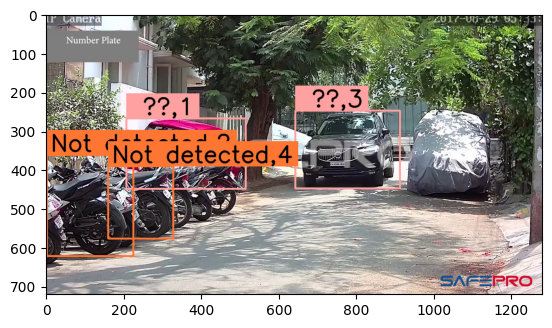

video 1/1 (frame 91/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.6ms

0: 384x640 (no detections), 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.9ms
Speed: 2.9ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 480x640 1 licence, 6.7ms
Speed: 1.6ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
 


0: 640x608 (no detections), 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 92/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.5ms

0: 384x640 (no detections), 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 0.5ms postprocess per imag

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

 


0: 640x608 (no detections), 8.0ms
Speed: 4.1ms preprocess, 8.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 93/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 9.3ms

0: 384x640 (no detections), 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 512x640 1 licence, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)
 


0: 640x608 (no detections), 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
Not detected


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

video 1/1 (frame 94/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 9.5ms

0: 384x640 (no detections), 7.6ms
Speed: 1.5ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.9ms
Speed: 2.9ms preprocess, 6.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 512x640 1 licence, 6.8ms
Speed: 1.6ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)
 


0: 640x608 (no detections), 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 95/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 8.4ms

0: 384x640 (no detections), 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 0.6ms postprocess per imag

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

video 1/1 (frame 96/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 8.0ms

0: 384x640 (no detections), 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.7ms
Speed: 2.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 512x640 1 licence, 6.6ms
Speed: 1.5ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


0: 640x608 (no detections), 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 97/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 9.0ms

0: 384x640 (no detections), 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 0.5ms postprocess per image 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

video 1/1 (frame 103/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 8.1ms

0: 384x640 (no detections), 7.7ms
Speed: 1.3ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 544x640 1 licence, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)
 


0: 640x608 (no detections), 7.6ms
Speed: 2.1ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 104/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.2ms

0: 384x640 (no detections), 7.8ms
Speed: 1.5ms preprocess, 7.8ms inference, 0.5ms postprocess per im

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w



0: 640x608 (no detections), 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 106/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.2ms

0: 384x640 (no detections), 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 544x640 1 licence, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


0: 640x608 (no detections), 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 107/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

video 1/1 (frame 109/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 9.8ms

0: 384x640 (no detections), 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 544x640 1 licence, 6.8ms
Speed: 1.6ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


0: 640x608 (no detections), 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 110/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 8.7ms

0: 384x640 (no detections), 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 0.6ms postprocess per imag

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

video 1/1 (frame 111/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 9.9ms

0: 384x640 (no detections), 7.6ms
Speed: 1.3ms preprocess, 7.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 544x640 1 licence, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


0: 640x608 (no detections), 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 112/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 10.6ms

0: 384x640 (no detections), 7.8ms
Speed: 1.4ms preprocess, 7.8ms inference, 0.5ms postprocess per ima

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

Not detected
video 1/1 (frame 113/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.3ms

0: 384x640 (no detections), 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 544x640 1 licence, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


0: 640x576 (no detections), 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected
video 1/1 (frame 114/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 8.6ms

0: 384x640 (no detections), 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 0.5ms postpro

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

video 1/1 (frame 115/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 8.3ms

0: 384x640 (no detections), 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.9ms
Speed: 2.8ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 544x640 1 licence, 6.9ms
Speed: 2.5ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


0: 640x576 (no detections), 7.7ms
Speed: 2.0ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)
Not detected
video 1/1 (frame 116/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 8.6ms

0: 384x640 (no detections), 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 0.5ms postprocess per imag

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

video 1/1 (frame 117/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 8.1ms

0: 384x640 (no detections), 7.8ms
Speed: 1.5ms preprocess, 7.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 544x640 1 licence, 7.3ms
Speed: 3.1ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


0: 640x608 (no detections), 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 118/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 8.1ms

0: 384x640 (no detections), 7.5ms
Speed: 1.4ms preprocess, 7.5ms inference, 0.5ms postprocess per imag

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

video 1/1 (frame 119/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 10.9ms

0: 384x640 (no detections), 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.9ms
Speed: 2.8ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 544x640 1 licence, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


0: 640x576 (no detections), 8.6ms
Speed: 2.6ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)
Not detected
video 1/1 (frame 120/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.8ms

0: 384x640 (no detections), 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 0.5ms postprocess per ima

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

 


0: 640x576 (no detections), 7.9ms
Speed: 3.6ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)
Not detected


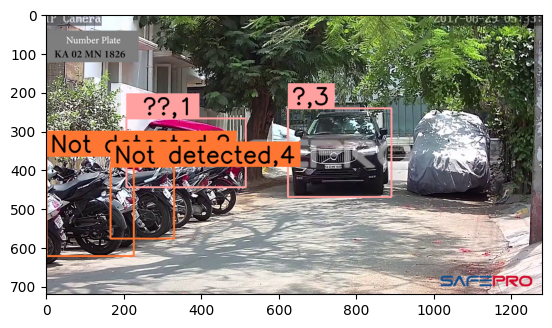

video 1/1 (frame 121/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 10.0ms

0: 384x640 (no detections), 7.7ms
Speed: 2.0ms preprocess, 7.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.0ms
Speed: 2.5ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 576x640 1 licence, 6.6ms
Speed: 2.6ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


0: 640x576 (no detections), 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected
video 1/1 (frame 122/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.4ms

0: 384x640 (no detections), 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 0.6ms postprocess per ima

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

video 1/1 (frame 123/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 8.1ms

0: 384x640 (no detections), 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 576x640 1 licence, 7.1ms
Speed: 2.6ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)
 


0: 640x576 (no detections), 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected
video 1/1 (frame 124/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 8.3ms

0: 384x640 (no detections), 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 0.6ms postprocess per im

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 576x640 1 licence, 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)
 


0: 640x608 (no detections), 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 135/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.5ms

0: 384x640 (no detections), 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.7ms
Speed: 2.7ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 576x640 1 licence, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


0: 640x608 (no detections), 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
Not detected


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

video 1/1 (frame 137/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.1ms

0: 384x640 (no detections), 7.6ms
Speed: 1.4ms preprocess, 7.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 576x640 1 licence, 7.1ms
Speed: 2.6ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)
 


0: 640x608 (no detections), 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 138/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 8.4ms

0: 384x640 (no detections), 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 0.6ms postprocess per im

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x608 (no detections), 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 (no detections), 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected
video 1/1 (frame 144/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 1 vase, 7.9ms

0: 384x640 (no detections), 7.6ms
Speed: 1.4ms preprocess, 7.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.9ms
Speed: 2.8ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 576x640 1 licence, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


0: 640x608 (no detections), 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x608 (no detections), 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 (no detections), 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected
video 1/1 (frame 146/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 1 vase, 7.7ms

0: 384x640 (no detections), 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 608x640 1 licence, 51.8ms
Speed: 1.9ms preprocess, 51.8ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


0: 640x608 (no detections), 8.1ms
Speed: 3.5ms preprocess, 8.1ms inference, 0.6ms postprocess per image at shape (1, 3

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x608 (no detections), 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 (no detections), 6.8ms
Speed: 2.7ms preprocess, 6.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Not detected
video 1/1 (frame 148/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 1 vase, 7.3ms

0: 384x640 (no detections), 7.7ms
Speed: 1.4ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.7ms
Speed: 2.8ms preprocess, 6.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 608x640 1 licence, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


0: 640x608 (no detections), 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 0.6ms postprocess per image at shape (1, 3, 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x608 (no detections), 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 (no detections), 7.6ms
Speed: 2.0ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected
video 1/1 (frame 150/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 1 vase, 8.0ms

0: 384x640 (no detections), 7.5ms
Speed: 1.4ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.7ms
Speed: 2.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 608x640 1 licence, 6.8ms
Speed: 2.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)
 


0: 640x608 (no detections), 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 0.7ms postprocess per image at shape (1, 3

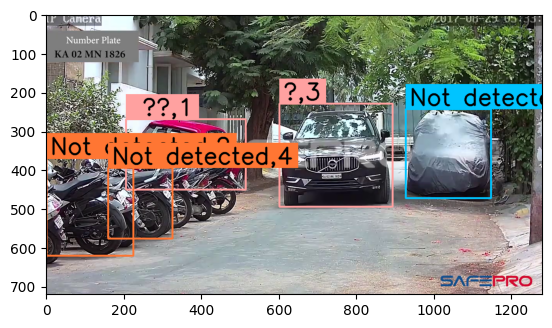

video 1/1 (frame 151/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 1 vase, 7.5ms

0: 384x640 (no detections), 7.6ms
Speed: 1.4ms preprocess, 7.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 608x640 1 licence, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)
 


0: 640x608 (no detections), 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 (no detections), 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected
video 1/1 (frame 152/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Rec

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

 


0: 640x608 (no detections), 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 (no detections), 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected
video 1/1 (frame 154/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 1 vase, 7.1ms

0: 384x640 (no detections), 7.8ms
Speed: 1.4ms preprocess, 7.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 608x640 1 licence, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)
 


0: 640x608 (no detections), 10.0ms
Speed: 3.1ms preprocess, 10.0ms inference, 0.8ms postprocess per image at shap

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x608 (no detections), 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 (no detections), 7.0ms
Speed: 2.6ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected
video 1/1 (frame 157/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 1 vase, 7.1ms

0: 384x640 (no detections), 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x608 (no detections), 6.9ms
Speed: 2.7ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 608x640 1 licence, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


0: 640x608 (no detections), 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 0.7ms postprocess per image at shape (1, 3, 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x608 (no detections), 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 (no detections), 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected
video 1/1 (frame 159/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 1 vase, 7.7ms

0: 384x640 (no detections), 7.6ms
Speed: 1.2ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 608x640 1 licence, 6.6ms
Speed: 2.7ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)
 


0: 640x608 (no detections), 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 0.9ms postprocess per image at shape (1, 3

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x608 (no detections), 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 (no detections), 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected
video 1/1 (frame 168/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 1 vase, 7.7ms

0: 384x640 (no detections), 7.6ms
Speed: 2.0ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 608x640 1 licence, 6.7ms
Speed: 2.7ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)
 


0: 640x608 (no detections), 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 0.7ms postprocess per image at shape (1, 3

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

 

 

£10204 1820)

 

 


0: 640x608 (no detections), 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 (no detections), 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected
video 1/1 (frame 170/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 1 vase, 7.2ms

0: 384x640 (no detections), 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 608x640 1 licence, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)
 




You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x608 (no detections), 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 (no detections), 6.9ms
Speed: 2.8ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected
video 1/1 (frame 171/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 1 vase, 7.4ms

0: 384x640 (no detections), 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.0ms
Speed: 2.7ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 608x640 1 licence, 7.1ms
Speed: 2.9ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)
 


0: 640x608 (no detections), 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x608 (no detections), 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 (no detections), 6.9ms
Speed: 2.8ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected
video 1/1 (frame 173/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 1 vase, 7.9ms

0: 384x640 (no detections), 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 608x640 1 licence, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)
 


0: 640x608 (no detections), 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 0.6ms postprocess per image at shape (1, 3

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x608 (no detections), 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 (no detections), 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected
video 1/1 (frame 175/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 1 vase, 7.9ms

0: 384x640 (no detections), 7.6ms
Speed: 1.3ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 608x640 1 licence, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)
 


0: 640x608 (no detections), 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x608 (no detections), 9.4ms
Speed: 2.1ms preprocess, 9.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 (no detections), 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected
video 1/1 (frame 177/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 1 vase, 8.2ms

0: 384x640 (no detections), 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 608x640 1 licence, 6.7ms
Speed: 2.7ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)
 


0: 640x608 (no detections), 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 0.6ms postprocess per image at shape (1, 3

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x608 (no detections), 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 (no detections), 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected
video 1/1 (frame 179/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.8ms

0: 384x640 (no detections), 7.6ms
Speed: 1.5ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.6ms
Speed: 2.7ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 608x640 1 licence, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)
<1 02MM 1820


0: 640x608 (no detections), 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x608 (no detections), 9.2ms
Speed: 2.4ms preprocess, 9.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected


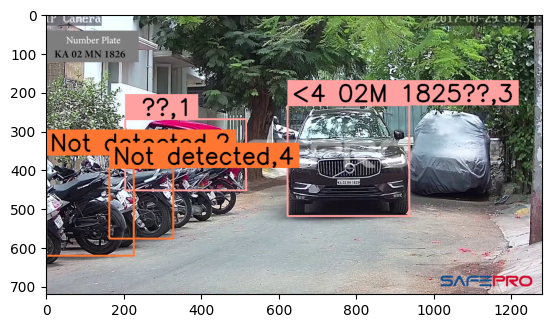

video 1/1 (frame 181/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 8.9ms

0: 384x640 (no detections), 7.8ms
Speed: 1.3ms preprocess, 7.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 608x640 1 licence, 6.9ms
Speed: 2.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)
<A 02MM 182


0: 640x608 (no detections), 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 182/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.3ms

0: 384x640 (no detections), 8.7ms
Speed: 2.0ms preprocess, 8.7ms inference, 0.6ms postproc

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x608 (no detections), 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 183/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.2ms

0: 384x640 (no detections), 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 576x640 1 licence, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)
<A 02MM 182


0: 640x608 (no detections), 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 184/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Re

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

video 1/1 (frame 186/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 9.8ms

0: 384x640 (no detections), 7.7ms
Speed: 1.4ms preprocess, 7.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 576x640 1 licence, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)
 

KLO2MN 1828


0: 640x608 (no detections), 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 187/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.5ms

0: 384x640 (no detections), 8.0ms
Speed: 1.3ms preprocess, 8.0ms inference, 0.6ms postp

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x608 (no detections), 7.6ms
Speed: 2.4ms preprocess, 7.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 188/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.2ms

0: 384x640 (no detections), 7.7ms
Speed: 1.4ms preprocess, 7.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 576x640 1 licence, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)
 


0: 640x608 (no detections), 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 189/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

KA O24N 1826


0: 640x608 (no detections), 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 190/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.1ms

0: 384x640 (no detections), 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.8ms
Speed: 2.6ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 576x640 1 licence, 6.6ms
Speed: 2.7ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)
 

KA O2HKN 1826




You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x608 (no detections), 8.9ms
Speed: 2.4ms preprocess, 8.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 191/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.3ms

0: 384x640 (no detections), 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.6ms
Speed: 2.6ms preprocess, 6.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 576x640 1 licence, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)
 

KA O2HKN 1826


0: 640x608 (no detections), 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 192/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Pla

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0: 640x608 (no detections), 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 194/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 8.3ms

0: 384x640 (no detections), 7.8ms
Speed: 2.0ms preprocess, 7.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 576x640 1 licence, 6.6ms
Speed: 2.7ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)
 


0: 640x608 (no detections), 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 195/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x608 (no detections), 8.4ms
Speed: 3.4ms preprocess, 8.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 196/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.0ms

0: 384x640 (no detections), 7.6ms
Speed: 1.5ms preprocess, 7.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 576x640 1 licence, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)
KA O2MN 1826


0: 640x608 (no detections), 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 197/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate R

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0: 640x608 (no detections), 7.5ms
Speed: 2.6ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 198/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 8.0ms

0: 384x640 (no detections), 7.4ms
Speed: 1.2ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 576x640 1 licence, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)
KA O2KN 1826

 


0: 640x608 (no detections), 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 199/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plat

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0: 640x608 (no detections), 8.9ms
Speed: 2.1ms preprocess, 8.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 200/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.0ms

0: 384x640 (no detections), 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.7ms
Speed: 2.5ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 576x640 1 licence, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 640)
KA O2KN 1826

 


0: 640x608 (no detections), 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 201/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plat

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x608 (no detections), 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 206/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 8.6ms

0: 384x640 (no detections), 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 576x640 1 licence, 6.7ms
Speed: 2.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)
KA O2KN 1826


0: 640x608 (no detections), 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 207/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate R

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0: 640x608 (no detections), 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 209/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 8.6ms

0: 384x640 (no detections), 7.9ms
Speed: 1.4ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 576x640 1 licence, 7.5ms
Speed: 3.1ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)
KA O2MM 1826


0: 640x608 (no detections), 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 210/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate R

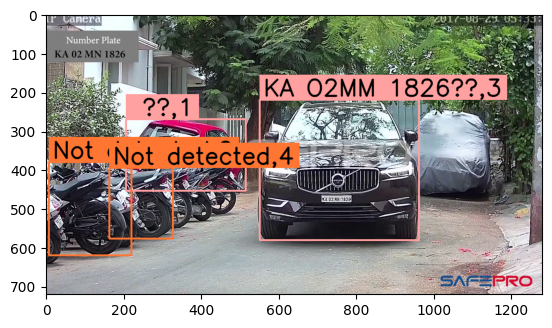

video 1/1 (frame 211/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.5ms

0: 384x640 (no detections), 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x576 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 576x640 1 licence, 6.5ms
Speed: 2.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)
 

KA O2KN 182¢


0: 640x608 (no detections), 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 212/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.9ms

0: 384x640 (no detections), 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 0.6ms post

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


KA O2HN 1826


0: 640x608 (no detections), 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 213/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.2ms

0: 384x640 (no detections), 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x608 (no detections), 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 576x640 1 licence, 6.7ms
Speed: 2.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)
KA O2 KN 1828




You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x608 (no detections), 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 214/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.2ms

0: 384x640 (no detections), 7.3ms
Speed: 1.3ms preprocess, 7.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x608 (no detections), 6.8ms
Speed: 2.7ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 576x640 2 licences, 6.9ms
Speed: 2.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)
Not detected

0: 640x608 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 215/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Re

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x608 (no detections), 9.5ms
Speed: 1.7ms preprocess, 9.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 223/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.1ms

0: 384x640 (no detections), 7.3ms
Speed: 1.3ms preprocess, 7.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x640 (no detections), 6.6ms
Speed: 2.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 576x640 2 licences, 7.0ms
Speed: 2.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)
Not detected

0: 640x608 (no detections), 6.5ms
Speed: 1.7ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 224/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Re

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0: 544x640 2 licences, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)
Not detected

0: 640x576 (no detections), 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected
video 1/1 (frame 236/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.6ms

0: 352x640 (no detections), 7.7ms
Speed: 1.2ms preprocess, 7.7ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)
Not detected

0: 640x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 544x640 2 licences, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)
Not detected

0: 640x576 (no detections), 6.8ms
Speed: 1.7ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 6

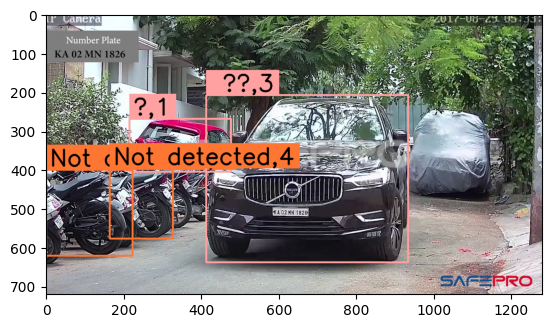

video 1/1 (frame 241/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 8.6ms

0: 352x640 (no detections), 8.3ms
Speed: 1.3ms preprocess, 8.3ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)
Not detected

0: 640x640 (no detections), 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 544x640 2 licences, 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)
Not detected

0: 640x576 (no detections), 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected
video 1/1 (frame 242/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.6ms

0: 352x640 (no detections), 8.2ms
Speed: 1.3ms preprocess, 8.2ms inference, 0.6ms postproc

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x576 (no detections), 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected
video 1/1 (frame 246/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.5ms

0: 352x640 (no detections), 7.6ms
Speed: 1.2ms preprocess, 7.6ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)
Not detected

0: 640x640 (no detections), 6.7ms
Speed: 2.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 544x640 1 licence, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)
KA O2 MN. 1826


0: 640x576 (no detections), 7.5ms
Speed: 2.6ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected
video 1/1 (frame 247/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x576 (no detections), 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected
video 1/1 (frame 248/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 2 motorcycles, 7.6ms

0: 352x640 (no detections), 7.6ms
Speed: 1.7ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)
Not detected

0: 640x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 512x640 2 licences, 6.6ms
Speed: 2.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)
Not detected

0: 640x576 (no detections), 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected
video 1/1 (frame 249/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Re

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 384x640 (no detections), 7.5ms
Speed: 1.7ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x608 (no detections), 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 512x640 1 licence, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)
AO2MN 1826

video 1/1 (frame 254/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 1 motorcycle, 7.6ms

0: 384x640 (no detections), 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x608 (no detections), 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 512x640 1 licence, 6.7ms
Speed: 2.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 512,

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x544 (no detections), 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 480x640 1 licence, 7.0ms
Speed: 2.9ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
KA O2KN 18261

video 1/1 (frame 256/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 1 motorcycle, 7.7ms

0: 640x512 (no detections), 54.0ms
Speed: 2.6ms preprocess, 54.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)
Not detected

0: 480x640 3 licences, 6.8ms
Speed: 3.2ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
Not detected
video 1/1 (frame 257/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 1 motorcycle, 7.2ms

0: 640x512 (no detections), 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 0.6ms postprocess pe

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


KA O2KN 1826

video 1/1 (frame 258/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 1 motorcycle, 7.9ms

0: 640x480 (no detections), 54.7ms
Speed: 1.7ms preprocess, 54.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 480x640 1 licence, 6.7ms
Speed: 3.0ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
KAO MN 1826

video 1/1 (frame 259/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 1 motorcycle, 7.5ms

0: 640x480 (no detections), 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 480x640 2 licences, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
Not detected
video 1/1 (frame 260/930) /kaggle/input/new-video/Automatic Number Plate Recognitio

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


video 1/1 (frame 265/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 6.8ms

0: 448x640 1 licence, 6.5ms
Speed: 2.7ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)
KO2HN 199)

video 1/1 (frame 266/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 truck, 8.2ms

0: 448x640 3 licences, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)
Not detected
video 1/1 (frame 267/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 truck, 7.7ms

0: 448x640 2 licences, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)
Not detected
video 1/1 (frame 268/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recogn

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


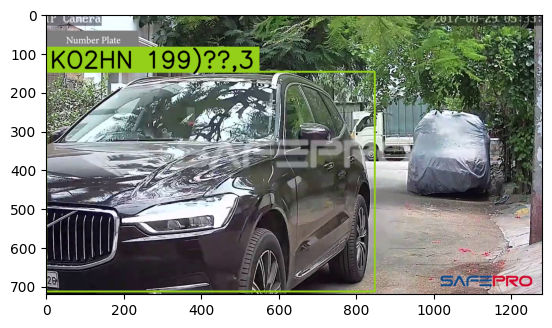

video 1/1 (frame 271/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 trucks, 7.5ms

0: 448x640 1 licence, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


0: 512x640 (no detections), 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)
Not detected
video 1/1 (frame 272/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 trucks, 7.3ms

0: 448x640 (no detections), 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)
Not detected

0: 512x640 (no detections), 6.6ms
Speed: 2.4ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)
Not detected
video 1/1 (frame 273/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

video 1/1 (frame 293/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 trucks, 9.3ms

0: 576x640 (no detections), 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)
Not detected

0: 512x640 (no detections), 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)
Not detected
video 1/1 (frame 294/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 trucks, 8.1ms

0: 576x640 (no detections), 6.6ms
Speed: 3.0ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)
Not detected

0: 512x640 (no detections), 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)
Not detected
video 1/1 (frame 295/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Pla

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

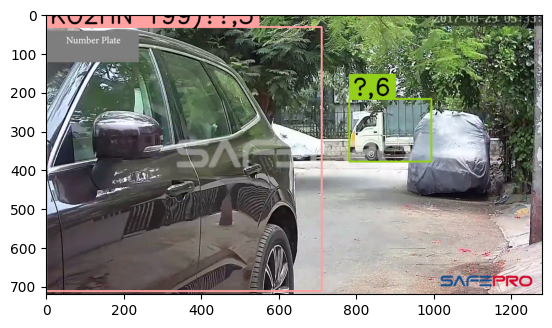

video 1/1 (frame 301/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 1 truck, 9.6ms

0: 640x640 (no detections), 7.1ms
Speed: 3.7ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 512x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)
Not detected
video 1/1 (frame 302/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 1 truck, 7.7ms

0: 640x640 (no detections), 6.7ms
Speed: 3.9ms preprocess, 6.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 512x640 1 licence, 6.7ms
Speed: 1.6ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

video 1/1 (frame 303/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Re

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w


video 1/1 (frame 305/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 1 truck, 9.4ms

0: 640x640 (no detections), 6.9ms
Speed: 2.6ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 512x640 1 licence, 6.8ms
Speed: 1.7ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

video 1/1 (frame 306/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 1 truck, 7.7ms

0: 640x608 (no detections), 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 512x640 1 licence, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w


video 1/1 (frame 307/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 1 truck, 8.1ms

0: 640x608 (no detections), 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 512x640 1 licence, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

video 1/1 (frame 308/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 1 truck, 8.5ms

0: 640x608 (no detections), 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 512x640 1 licence, 6.7ms
Speed: 1.6ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w


video 1/1 (frame 309/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 1 truck, 8.3ms

0: 640x576 (no detections), 7.0ms
Speed: 3.1ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 512x640 1 licence, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

video 1/1 (frame 310/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 1 truck, 8.9ms



You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x576 (no detections), 7.6ms
Speed: 3.4ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 512x640 1 licence, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

video 1/1 (frame 311/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 1 truck, 7.9ms

0: 640x576 (no detections), 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 512x640 1 licence, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

video 1/1 (frame 312/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 1 truck, 7.7ms

0: 640x576 (no detections), 6.9ms
Speed: 3.2ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

video 1/1 (frame 313/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 1 truck, 7.0ms

0: 640x544 (no detections), 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 512x640 (no detections), 6.8ms
Speed: 1.6ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)
Not detected
video 1/1 (frame 314/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 1 truck, 7.1ms

0: 640x544 (no detections), 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 512x640 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)
Not detected
video 1/1 (frame 315/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicl

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x480 (no detections), 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 512x640 (no detections), 7.3ms
Speed: 2.5ms preprocess, 7.3ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)
Not detected
video 1/1 (frame 322/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 1 truck, 7.1ms

0: 640x480 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 512x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)
Not detected
video 1/1 (frame 323/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 1 truck, 7.5ms

0: 640x448 (no detections), 54.2ms
Speed: 1.8ms preprocess, 54.2ms inference, 0.6ms postprocess per 

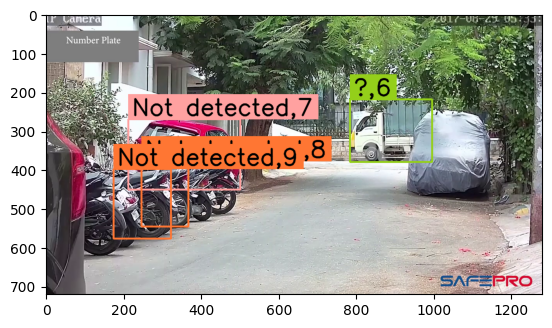

video 1/1 (frame 331/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 3 motorcycles, 1 truck, 7.6ms

0: 512x640 (no detections), 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)
Not detected

0: 416x640 (no detections), 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)
Not detected

0: 640x480 (no detections), 7.5ms
Speed: 1.6ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x384 (no detections), 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)
Not detected
video 1/1 (frame 332/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle N

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x512 (no detections), 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)
Not detected

0: 640x576 (no detections), 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 640x576 (no detections), 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected
video 1/1 (frame 349/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 3 motorcycles, 1 truck, 7.0ms

0: 480x640 (no detections), 7.2ms
Speed: 1.6ms preprocess, 7.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)
Not detected

0: 384x640 1 licence, 7.6ms
Speed: 1.5ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
 


0: 640x512 (no detections), 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 0.7ms postprocess per image at shape (1, 3

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x512 (no detections), 9.5ms
Speed: 2.6ms preprocess, 9.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)
Not detected

0: 640x576 (no detections), 7.1ms
Speed: 2.6ms preprocess, 7.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 640x576 (no detections), 6.4ms
Speed: 2.7ms preprocess, 6.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected
video 1/1 (frame 351/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 3 motorcycles, 1 truck, 7.3ms

0: 480x640 (no detections), 7.1ms
Speed: 1.7ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)
Not detected

0: 384x640 1 licence, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
 


0: 640x512 (no detections), 7.8ms
Speed: 1.7ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

Speed: 2.5ms preprocess, 7.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)
Not detected

0: 640x576 (no detections), 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 640x608 (no detections), 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected
video 1/1 (frame 353/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 1 car, 3 motorcycles, 1 truck, 8.0ms

0: 480x640 (no detections), 6.6ms
Speed: 1.5ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)
Not detected

0: 384x640 (no detections), 7.8ms
Speed: 1.4ms preprocess, 7.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x512 (no detections), 6.7ms
Speed: 2.3ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 512)
Not det

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w


video 1/1 (frame 360/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 3 motorcycles, 1 truck, 9.6ms

0: 512x640 (no detections), 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)
Not detected

0: 384x640 (no detections), 7.7ms
Speed: 1.4ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x512 (no detections), 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 512)
Not detected

0: 640x576 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 640x608 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 1 licence, 7.1ms
Speed: 2.9ms preprocess, 7.1ms inference, 1.2ms postprocess per image a

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


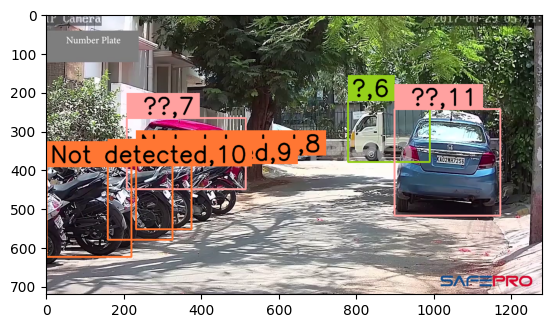

video 1/1 (frame 361/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 3 motorcycles, 1 truck, 7.4ms

0: 512x640 (no detections), 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)
Not detected

0: 384x640 (no detections), 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x512 (no detections), 6.6ms
Speed: 1.5ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 512)
Not detected

0: 640x576 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 640x608 (no detections), 6.6ms
Speed: 2.7ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 1 licence, 6.7ms
Speed: 2.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

 

video 1/1 (frame 363/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 3 motorcycles, 1 truck, 7.6ms

0: 512x640 (no detections), 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)
Not detected

0: 384x640 (no detections), 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x512 (no detections), 6.7ms
Speed: 1.6ms preprocess, 6.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)
Not detected

0: 640x576 (no detections), 6.8ms
Speed: 2.5ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 640x608 (no detections), 6.9ms
Speed: 2.7ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 1 licence, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.1ms postprocess per image

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w


video 1/1 (frame 364/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 3 motorcycles, 1 truck, 7.7ms

0: 512x640 (no detections), 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)
Not detected

0: 384x640 (no detections), 7.3ms
Speed: 1.4ms preprocess, 7.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.0ms
Speed: 1.7ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x576 (no detections), 6.8ms
Speed: 2.5ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 640x608 (no detections), 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 1 licence, 6.9ms
Speed: 2.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image a

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w


video 1/1 (frame 367/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 3 motorcycles, 1 truck, 8.0ms

0: 512x640 (no detections), 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)
Not detected

0: 384x640 (no detections), 8.1ms
Speed: 1.5ms preprocess, 8.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x512 (no detections), 7.0ms
Speed: 1.7ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)
Not detected

0: 640x576 (no detections), 6.7ms
Speed: 2.5ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 640x608 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 1 licence, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.1ms postprocess per image a

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w


video 1/1 (frame 368/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 3 motorcycles, 1 truck, 8.3ms

0: 512x640 (no detections), 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)
Not detected

0: 384x640 (no detections), 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.1ms
Speed: 2.2ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x576 (no detections), 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected

0: 640x608 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 1 licence, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.1ms postprocess per image a

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

video 1/1 (frame 369/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 3 motorcycles, 1 truck, 8.1ms

0: 512x640 (no detections), 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)
Not detected

0: 384x640 (no detections), 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.9ms
Speed: 2.2ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x608 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 1 licence, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.2ms postprocess per image at 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w


video 1/1 (frame 371/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 3 motorcycles, 1 truck, 7.9ms

0: 512x640 (no detections), 6.9ms
Speed: 1.6ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)
Not detected

0: 384x640 (no detections), 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.9ms
Speed: 2.2ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x608 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 1 licence, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image a

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

video 1/1 (frame 372/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 3 motorcycles, 1 truck, 7.4ms

0: 512x640 (no detections), 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)
Not detected

0: 384x640 (no detections), 7.3ms
Speed: 1.4ms preprocess, 7.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.6ms
Speed: 1.6ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.5ms
Speed: 1.7ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x608 (no detections), 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 1 licence, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.1ms postprocess per image at 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w


video 1/1 (frame 374/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 3 motorcycles, 1 truck, 8.1ms

0: 512x640 (no detections), 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)
Not detected

0: 384x640 (no detections), 8.0ms
Speed: 1.4ms preprocess, 8.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.6ms
Speed: 1.6ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x608 (no detections), 7.0ms
Speed: 2.7ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 1 licence, 6.7ms
Speed: 2.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image a

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w


video 1/1 (frame 375/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 3 motorcycles, 1 truck, 7.8ms

0: 512x640 (no detections), 7.2ms
Speed: 1.7ms preprocess, 7.2ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)
Not detected

0: 384x640 (no detections), 7.6ms
Speed: 1.4ms preprocess, 7.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x608 (no detections), 7.0ms
Speed: 2.7ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 1 licence, 6.6ms
Speed: 2.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image a

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w


video 1/1 (frame 376/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 2 cars, 3 motorcycles, 1 truck, 8.4ms

0: 512x640 (no detections), 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)
Not detected

0: 384x640 (no detections), 7.8ms
Speed: 1.4ms preprocess, 7.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.9ms
Speed: 1.7ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)




You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x608 (no detections), 8.9ms
Speed: 4.0ms preprocess, 8.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 1 licence, 7.1ms
Speed: 3.0ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

video 1/1 (frame 377/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 1 truck, 7.8ms

0: 512x640 (no detections), 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)
Not detected

0: 384x640 (no detections), 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 9.9ms
Speed: 2.5ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w



0: 640x608 (no detections), 11.2ms
Speed: 3.1ms preprocess, 11.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 1 licence, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


0: 352x640 1 licence, 8.5ms
Speed: 1.9ms preprocess, 8.5ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

 

video 1/1 (frame 378/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 1 truck, 8.0ms

0: 512x640 (no detections), 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)
Not detected

0: 384x640 (no detections), 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


0: 640x608 (no detections), 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 1 licence, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 352x640 (no detections), 11.0ms
Speed: 2.8ms preprocess, 11.0ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)
Not detected
video 1/1 (frame 379/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 1 truck, 11.8ms

0: 512x640 (no detections), 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)
Not detected

0: 384x640 (no detections), 11.1ms
Speed: 2.1ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)




You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x608 (no detections), 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 1 licence, 6.8ms
Speed: 2.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
BK AQ2MH725¢


0: 352x640 (no detections), 8.3ms
Speed: 1.9ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)
Not detected
video 1/1 (frame 380/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 1 truck, 7.4ms

0: 512x640 (no detections), 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)
Not detected

0: 384x640 (no detections), 7.8ms
Speed: 2.0ms preprocess, 7.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 0.5ms postprocess per image at

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w



0: 384x640 (no detections), 8.2ms
Speed: 1.9ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


0: 640x640 (no detections), 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

BK AQ2MH725¢


0: 352x640 (no detections), 8.8ms
Speed: 1.5ms preprocess, 8.8ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)
Not detected
video 1/1 (frame 382/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 1 truck, 7.4ms

0: 512x640 1 licence, 7.0ms
Speed: 1.7ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


0: 384x640 (no detections), 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


0: 640x640 (no detections), 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 0.7ms postprocess per image at shape (1, 3, 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

BK AQ2MH725¢


0: 352x640 (no detections), 8.1ms
Speed: 1.4ms preprocess, 8.1ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)
Not detected
video 1/1 (frame 383/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 1 truck, 7.2ms

0: 512x640 1 licence, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


0: 384x640 (no detections), 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


0: 640x640 (no detections), 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

BK AQ2MH725¢


0: 352x640 (no detections), 9.0ms
Speed: 1.5ms preprocess, 9.0ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 640)
Not detected
video 1/1 (frame 384/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 1 truck, 8.4ms

0: 512x640 1 licence, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


0: 384x640 (no detections), 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 7.0ms
Speed: 2.4ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


0: 640x608 (no detections), 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

BK AQ2MH725¢


0: 352x640 (no detections), 8.0ms
Speed: 1.3ms preprocess, 8.0ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)
Not detected
video 1/1 (frame 385/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 1 truck, 7.4ms

0: 512x640 1 licence, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


0: 384x640 (no detections), 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.8ms
Speed: 1.7ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.8ms
Speed: 2.5ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


0: 640x640 (no detections), 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 0.6ms postprocess per image at shape (1, 3, 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

BK AQ2MH725¢


0: 352x640 (no detections), 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)
Not detected
video 1/1 (frame 386/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 1 truck, 7.1ms

0: 512x640 1 licence, 6.8ms
Speed: 1.7ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


0: 384x640 (no detections), 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.0ms
Speed: 1.6ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


0: 640x608 (no detections), 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 0.6ms postprocess per image at shape (1, 3, 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

BK AQ2MH725¢


0: 352x640 (no detections), 8.4ms
Speed: 1.8ms preprocess, 8.4ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)
Not detected
video 1/1 (frame 387/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 1 truck, 7.2ms

0: 512x640 1 licence, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


0: 384x640 (no detections), 8.6ms
Speed: 2.0ms preprocess, 8.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.1ms
Speed: 1.6ms preprocess, 7.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


0: 640x608 (no detections), 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

BX AO2HH725¢


0: 352x640 (no detections), 8.2ms
Speed: 1.5ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 640)
Not detected
video 1/1 (frame 388/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 1 truck, 8.5ms

0: 512x640 1 licence, 6.8ms
Speed: 1.7ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)
 


0: 384x640 (no detections), 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.1ms
Speed: 1.7ms preprocess, 7.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 7.8ms
Speed: 1.6ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w



0: 640x608 (no detections), 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 1 licence, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
XAO2MH725¢




You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 320x640 (no detections), 53.2ms
Speed: 1.5ms preprocess, 53.2ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)
Not detected
video 1/1 (frame 389/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 1 truck, 7.6ms

0: 512x640 1 licence, 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)
 


0: 384x640 (no detections), 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 7.0ms
Speed: 2.6ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


0: 640x608 (no detections), 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
No

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

 

video 1/1 (frame 390/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 1 truck, 7.7ms

0: 512x640 1 licence, 7.0ms
Speed: 1.7ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)
 


0: 384x640 (no detections), 8.9ms
Speed: 2.0ms preprocess, 8.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 9.6ms
Speed: 2.4ms preprocess, 9.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.9ms
Speed: 1.7ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w



0: 640x608 (no detections), 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 1 licence, 7.1ms
Speed: 3.0ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
XAO2MH7 256


0: 320x640 (no detections), 8.2ms
Speed: 1.5ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)
Not detected


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

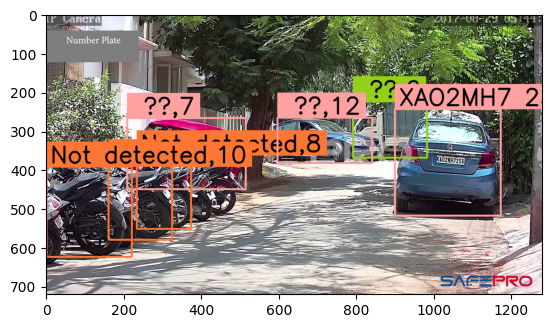

video 1/1 (frame 391/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 1 truck, 7.4ms

0: 512x640 1 licence, 6.8ms
Speed: 1.7ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)
 


0: 384x640 (no detections), 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.7ms
Speed: 1.5ms preprocess, 6.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


0: 640x608 (no detections), 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 1 licence, 8.9ms
Speed: 2.0ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
XAO2MH7 2

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

 

video 1/1 (frame 392/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 1 truck, 8.3ms

0: 512x640 1 licence, 6.9ms
Speed: 1.6ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)
 


0: 384x640 (no detections), 7.8ms
Speed: 1.6ms preprocess, 7.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.6ms
Speed: 1.6ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w



0: 640x608 (no detections), 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 1 licence, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
XAO2MH7 256


0: 320x640 1 licence, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w


video 1/1 (frame 393/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 1 truck, 7.4ms

0: 480x640 1 licence, 6.8ms
Speed: 1.6ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
 


0: 384x640 (no detections), 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




0: 640x608 (no detections), 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 1 licence, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
 


0: 320x640 1 licence, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

 

video 1/1 (frame 394/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 1 truck, 8.1ms

0: 480x640 1 licence, 6.9ms
Speed: 2.2ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
 


0: 384x640 (no detections), 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.7ms
Speed: 1.6ms preprocess, 6.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w



0: 640x608 (no detections), 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 1 licence, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
 


0: 320x640 1 licence, 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

 

video 1/1 (frame 395/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 1 truck, 7.8ms

0: 480x640 1 licence, 6.9ms
Speed: 1.4ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
 


0: 384x640 (no detections), 8.5ms
Speed: 1.6ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w



0: 640x608 (no detections), 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 1 licence, 6.7ms
Speed: 3.0ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
 


0: 320x640 (no detections), 7.9ms
Speed: 1.3ms preprocess, 7.9ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)
Not detected
video 1/1 (frame 396/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 1 truck, 7.3ms

0: 480x640 1 licence, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

 


0: 384x640 (no detections), 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.7ms
Speed: 1.6ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


0: 640x608 (no detections), 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)
Not detected

0: 640x640 1 licence, 6.9ms
Speed: 3.0ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
 


0: 288x640 (no detections), 51.4ms
Speed: 1.5ms preprocess, 51.4ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)
Not detected


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

video 1/1 (frame 397/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 1 truck, 9.8ms

0: 480x640 1 licence, 6.8ms
Speed: 1.5ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
 


0: 384x640 (no detections), 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


0: 640x640 (no detections), 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


0: 288

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

 

video 1/1 (frame 398/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 1 truck, 8.3ms

0: 480x640 1 licence, 6.9ms
Speed: 1.6ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
 


0: 384x640 (no detections), 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.1ms
Speed: 2.2ms preprocess, 7.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w



0: 640x640 (no detections), 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
XAO2MH725¢


0: 288x640 1 licence, 12.7ms
Speed: 2.0ms preprocess, 12.7ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

 

video 1/1 (frame 399/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 1 truck, 7.6ms

0: 480x640 1 licence, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


0: 384x640 (no detections), 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 8.7ms
Speed: 1.9ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w



0: 640x640 (no detections), 7.5ms
Speed: 3.1ms preprocess, 7.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.2ms
Speed: 2.9ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 288x640 (no detections), 8.0ms
Speed: 1.3ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)
Not detected
video 1/1 (frame 400/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.3ms

0: 384x640 (no detections), 7.7ms
Speed: 2.0ms preprocess, 7.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 7.1ms
Speed: 2.5ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w



0: 640x640 (no detections), 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.3ms
Speed: 3.0ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
BK AQ2MH725¢


0: 288x640 (no detections), 8.0ms
Speed: 1.4ms preprocess, 8.0ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)
Not detected
video 1/1 (frame 401/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.5ms

0: 384x640 (no detections), 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected



You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x480 (no detections), 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.8ms
Speed: 1.6ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


0: 640x640 (no detections), 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
BK AQ2MH725¢


0: 288x640 (no detections), 9.5ms
Speed: 1.4ms preprocess, 9.5ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)
Not detected
video 1/1 (frame 402/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.4ms

0: 384x640 (no detections), 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
No

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x480 (no detections), 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.3ms
Speed: 2.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
BK AQ2MH725¢


0: 288x640 (no detections), 8.1ms
Speed: 1.3ms preprocess, 8.1ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)
Not detected
video 1/1 (frame 403/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.2ms

0: 384x640 (no detections), 7.5ms
Speed: 1.4ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

BK AQ2MH725¢


0: 288x640 1 licence, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
 

video 1/1 (frame 405/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 8.3ms

0: 384x640 (no detections), 7.6ms
Speed: 1.3ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.8ms
Speed: 1.6ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


0: 640x640 (no detections), 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 2 licences, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
No

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 288x640 1 licence, 9.1ms
Speed: 1.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)
 

video 1/1 (frame 406/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 8.4ms

0: 384x640 (no detections), 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.3ms
Speed: 2.5ms preprocess, 7.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 2 licences, 6.1ms
Speed: 2.8ms preprocess, 6.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
N

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

 

video 1/1 (frame 407/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.6ms

0: 384x640 (no detections), 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.8ms
Speed: 1.6ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 2 licences, 6.0ms
Speed: 2.8ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 288x640 1 licence, 7.6ms
Speed: 1.1ms preprocess, 7.6ms inference, 1.1ms postprocess per image at shape (1, 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

 

video 1/1 (frame 408/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.7ms

0: 384x640 (no detections), 8.4ms
Speed: 1.5ms preprocess, 8.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.8ms
Speed: 1.7ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 2 licences, 6.3ms
Speed: 2.8ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 288x640 1 licence, 8.3ms
Speed: 1.5ms preprocess, 8.3ms inference, 1.1ms postprocess per image at shape (1, 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w


video 1/1 (frame 409/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.5ms

0: 384x640 (no detections), 7.6ms
Speed: 1.3ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.9ms
Speed: 1.7ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 2 licences, 6.1ms
Speed: 2.8ms preprocess, 6.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 288x640 1 licence, 7.2ms
Speed: 1.3ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3,

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w


video 1/1 (frame 411/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.3ms

0: 416x640 (no detections), 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)
Not detected

0: 640x480 (no detections), 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 7.0ms
Speed: 2.5ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 2 licences, 6.1ms
Speed: 2.0ms preprocess, 6.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 288x640 1 licence, 7.9ms
Speed: 1.5ms preprocess, 7.9ms inference, 1.1ms postprocess per image at shape (1, 3,

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

 

video 1/1 (frame 413/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 8.9ms

0: 416x640 (no detections), 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)
Not detected

0: 640x480 (no detections), 6.7ms
Speed: 1.6ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.7ms
Speed: 1.6ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 6.8ms
Speed: 2.7ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 2 licences, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 320x640 1 licence, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.1ms postprocess per image at shape (1, 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

video 1/1 (frame 414/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 8.2ms

0: 416x640 (no detections), 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)
Not detected

0: 640x480 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 2 licences, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 320x640 1 licence, 7.7ms
Speed: 1.6ms preprocess, 7.7ms inference, 1.1ms postprocess per image at shape (1, 3, 3

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w



0: 320x640 1 licence, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

video 1/1 (frame 416/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.9ms

0: 416x640 (no detections), 7.2ms
Speed: 1.6ms preprocess, 7.2ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)
Not detected

0: 640x480 (no detections), 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)
Not detected



You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x640 (no detections), 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 2 licences, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 320x640 1 licence, 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)

video 1/1 (frame 417/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 8.5ms

0: 416x640 (no detections), 7.6ms
Speed: 1.5ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)
Not detected

0: 640x480 (no detections), 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)
Not

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

EXAO2MH7256


0: 320x640 1 licence, 9.4ms
Speed: 1.7ms preprocess, 9.4ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)

video 1/1 (frame 420/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.8ms

0: 416x640 (no detections), 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)
Not detected

0: 640x480 (no detections), 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected



You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0: 640x640 1 licence, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
EXAO2MH7256


0: 320x640 1 licence, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)



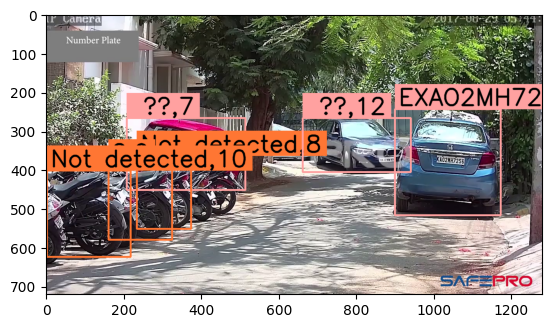

video 1/1 (frame 421/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.5ms

0: 416x640 (no detections), 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)
Not detected

0: 640x480 (no detections), 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 6.6ms
Speed: 3.1ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.1ms
Speed: 2.8ms preprocess, 6.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
EXAO2MH7256


0: 352x640 1 licence, 8.1ms
Speed: 1.5ms preprocess, 8.1ms inference, 1.3ms postprocess per image at shape (1, 3, 3

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

EXAO2MH7256


0: 352x640 1 licence, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)
 

video 1/1 (frame 423/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.5ms

0: 416x640 (no detections), 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)
Not detected

0: 640x480 (no detections), 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 6.9ms
Speed: 2.7ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

EXAO2MH7256


0: 352x640 1 licence, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)
 

video 1/1 (frame 424/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.8ms

0: 416x640 (no detections), 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)
Not detected

0: 640x480 (no detections), 6.9ms
Speed: 1.7ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 7.0ms
Speed: 1.7ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.0ms
Speed: 2.8ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

EXAO2MH7256


0: 352x640 1 licence, 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)
 

video 1/1 (frame 425/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.6ms

0: 416x640 (no detections), 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)
Not detected

0: 640x480 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 6.6ms
Speed: 2.7ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.2ms
Speed: 2.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

EXAO2MH7256


0: 352x640 1 licence, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)
 

video 1/1 (frame 426/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.6ms

0: 416x640 (no detections), 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)
Not detected

0: 640x480 (no detections), 6.8ms
Speed: 1.7ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

EXAO2MH7256


0: 352x640 1 licence, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

video 1/1 (frame 427/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.8ms

0: 416x640 (no detections), 6.9ms
Speed: 1.4ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)
Not detected

0: 640x480 (no detections), 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 7.0ms
Speed: 2.4ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 6.8ms
Speed: 2.8ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.0ms
Speed: 1.9ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3,

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

EXAO2MH7256


0: 384x640 1 licence, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

video 1/1 (frame 429/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.5ms

0: 384x640 (no detections), 6.8ms
Speed: 1.4ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3,

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


EXAO2MH7256


0: 384x640 1 licence, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
 

‘A thane)

video 1/1 (frame 431/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.5ms

0: 384x640 (no detections), 6.9ms
Speed: 1.5ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.5ms
Speed: 1.7ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.0ms
Speed: 2.8ms preprocess, 6.0ms inference, 1.1ms postprocess per image at

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


EXAO2MH7256


0: 384x640 1 licence, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
 

video 1/1 (frame 432/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.8ms

0: 384x640 (no detections), 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.8ms
Speed: 1.6ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.7ms
Speed: 1.6ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 2.0ms postprocess per image at shape (1, 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

EXAO2MH7256


0: 384x640 1 licence, 8.4ms
Speed: 1.9ms preprocess, 8.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
 

video 1/1 (frame 433/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.7ms

0: 416x640 (no detections), 6.9ms
Speed: 1.6ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)
Not detected

0: 640x480 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.1ms
Speed: 2.0ms preprocess, 6.1ms inference, 1.1ms postprocess per image at shape (1, 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

EXAO2MH7256


0: 416x640 1 licence, 7.6ms
Speed: 1.7ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)
 

video 1/1 (frame 434/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 9.2ms

0: 416x640 (no detections), 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)
Not detected

0: 640x480 (no detections), 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.6ms
Speed: 1.6ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 6.8ms
Speed: 2.7ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.2ms
Speed: 2.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

EXAO2MH7256


0: 416x640 1 licence, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)
 

video 1/1 (frame 435/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.8ms

0: 416x640 (no detections), 6.5ms
Speed: 1.5ms preprocess, 6.5ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)
Not detected

0: 640x480 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.1ms
Speed: 2.0ms preprocess, 6.1ms inference, 1.1ms postprocess per image at shape (1, 

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

EXAO2MH7256


0: 416x640 1 licence, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)
“ch TMM!

video 1/1 (frame 436/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.6ms

0: 384x640 (no detections), 7.6ms
Speed: 1.3ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.7ms
Speed: 2.3ms preprocess, 6.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 6.8ms
Speed: 2.7ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.1ms
Speed: 1.9ms preprocess, 6.1ms inference, 1.1ms postprocess per image at sha

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 416x640 1 licence, 8.8ms
Speed: 1.8ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)
 

video 1/1 (frame 437/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.5ms

0: 416x640 (no detections), 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)
Not detected

0: 640x480 (no detections), 6.9ms
Speed: 1.7ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.1ms
Speed: 2.0ms preprocess, 6.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

 

video 1/1 (frame 438/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 8.1ms

0: 416x640 (no detections), 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)
Not detected

0: 640x480 (no detections), 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 (no detections), 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)
Not detected

0: 640x640 (no detections), 6.8ms
Speed: 2.7ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.0ms
Speed: 2.7ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)




You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 416x640 1 licence, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)
 

video 1/1 (frame 439/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.8ms

0: 416x640 (no detections), 6.7ms
Speed: 1.4ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)
Not detected

0: 640x480 (no detections), 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


0: 640x640 (no detections), 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.4ms
Speed: 2.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w



0: 448x640 1 licence, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
 

video 1/1 (frame 440/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 8.0ms

0: 416x640 (no detections), 6.9ms
Speed: 1.4ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)
Not detected

0: 640x480 (no detections), 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.8ms
Speed: 1.7ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w



0: 640x640 (no detections), 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.2ms
Speed: 2.7ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


0: 448x640 1 licence, 8.3ms
Speed: 1.9ms preprocess, 8.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

 

video 1/1 (frame 441/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.8ms

0: 384x640 (no detections), 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.0ms
Speed: 2.4ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


0: 640x640 (no detections), 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.5ms
Speed: 2.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w



0: 448x640 1 licence, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

video 1/1 (frame 442/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.8ms

0: 384x640 (no detections), 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.7ms
Speed: 1.6ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w



0: 640x640 (no detections), 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.6ms
Speed: 3.2ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


0: 448x640 1 licence, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w


video 1/1 (frame 443/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.8ms

0: 384x640 (no detections), 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.8ms
Speed: 1.7ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


0: 640x640 (no detections), 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.2ms
Speed: 2.8ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


0: 448x640 1 licence, 7.6ms
Speed: 1.7ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

 

video 1/1 (frame 444/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 8.3ms

0: 384x640 (no detections), 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


0: 640x640 (no detections), 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.9ms
Speed: 3.0ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w



0: 448x640 1 licence, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

video 1/1 (frame 445/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.4ms

0: 384x640 (no detections), 7.6ms
Speed: 1.3ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w



0: 640x640 (no detections), 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.8ms
Speed: 2.9ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


0: 448x640 1 licence, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w


video 1/1 (frame 446/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.7ms

0: 384x640 (no detections), 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.8ms
Speed: 1.6ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


0: 640x640 (no detections), 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.4ms
Speed: 2.8ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


0: 480x640 1 licence, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w


video 1/1 (frame 447/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.6ms

0: 384x640 (no detections), 7.5ms
Speed: 1.4ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.6ms
Speed: 1.6ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


0: 640x640 (no detections), 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


0: 480x640 1 licence, 7.9ms
Speed: 2.1ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

Kaz men 00

video 1/1 (frame 448/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 8.0ms

0: 384x640 (no detections), 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


0: 640x640 (no detections), 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w



0: 480x640 1 licence, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
Kaz men 00

video 1/1 (frame 449/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 8.1ms

0: 384x640 (no detections), 7.5ms
Speed: 1.5ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.9ms
Speed: 1.7ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w



0: 640x640 (no detections), 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


0: 480x640 1 licence, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w


video 1/1 (frame 450/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.8ms

0: 384x640 (no detections), 7.8ms
Speed: 1.4ms preprocess, 7.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


0: 640x640 (no detections), 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


0: 480x640 1 licence, 7.6ms
Speed: 2.0ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

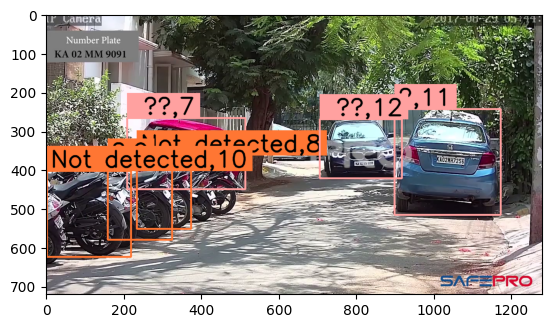

video 1/1 (frame 451/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 9.6ms

0: 384x640 (no detections), 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.7ms
Speed: 2.5ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


0: 640x640 (no detections), 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


0: 480x640 1 licence, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w


video 1/1 (frame 452/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 8.6ms

0: 384x640 (no detections), 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.9ms
Speed: 1.6ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


0: 640x640 (no detections), 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.6ms
Speed: 2.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


0: 480x640 1 licence, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

 

video 1/1 (frame 453/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.7ms

0: 384x640 (no detections), 7.8ms
Speed: 1.2ms preprocess, 7.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.7ms
Speed: 1.5ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


0: 640x640 (no detections), 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.7ms
Speed: 3.1ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w



0: 480x640 1 licence, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
 

video 1/1 (frame 454/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.7ms

0: 384x640 (no detections), 7.7ms
Speed: 1.4ms preprocess, 7.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.8ms
Speed: 1.7ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w



0: 640x640 (no detections), 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


0: 480x640 1 licence, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

 

video 1/1 (frame 455/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 8.0ms

0: 384x640 (no detections), 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x544 1 licence, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


0: 640x640 (no detections), 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 9.2ms
Speed: 2.0ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w



0: 480x640 1 licence, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
 

video 1/1 (frame 456/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.8ms

0: 384x640 (no detections), 7.6ms
Speed: 1.4ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x576 (no detections), 6.9ms
Speed: 2.5ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Not detected



You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

0: 640x640 (no detections), 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 6.2ms
Speed: 2.9ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


0: 480x640 1 licence, 8.3ms
Speed: 1.9ms preprocess, 8.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

video 1/1 (frame 457/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 8.5ms

0: 384x640 (no detections), 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 10.0ms
Speed: 2.3ms preprocess, 10.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x576 (no detections), 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
You are setting values through chained assignment. Currently this w

Not detected

0: 640x640 (no detections), 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 640x640 1 licence, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Not detected

0: 512x640 1 licence, 10.5ms
Speed: 2.8ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)
XA 02MM BOS

video 1/1 (frame 458/930) /kaggle/input/new-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4: 384x640 3 cars, 3 motorcycles, 7.7ms

0: 384x640 (no detections), 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Not detected

0: 640x480 (no detections), 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Not detected

0: 640x576 (no detections), 7.1ms
Speed: 2.5ms preprocess, 7.1ms inference, 0.5ms postprocess per image at

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

KeyboardInterrupt



In [24]:
counter = 0
result = model.track(video,persist=True,stream = True,tracker = "bytetrack.yaml")
iteration = iter(result)
for x in iteration:
    results = x
    img = results.orig_img
    counter += 1;
    detections = sv.Detections.from_ultralytics(results)
    if results.boxes.id is not None:
        detections.tracker_id = results.boxes.id.cpu().numpy().astype(int)
    labels = list()
    for x in range(detections.xyxy.shape[0]):
        image = img[int(detections.xyxy[x][1]):int(detections.xyxy[x][3]),int(detections.xyxy[x][0]):int(detections.xyxy[x][2])]
        area = (int(detections.xyxy[x][1])-int(detections.xyxy[x][3]))*(int(detections.xyxy[x][0])-int(detections.xyxy[x][2]))
        ans = ToNumPlate(image)
        print(ans)
        ans = UpdateLog(Log,detections.tracker_id[x],ans,area)
        labels.append(f"{ans},{detections.tracker_id[x]}")
#         plt.imshow(image)
#         plt.show()
    if counter%30 == 0:
        frame = box_annotator.annotate(scene = img,detections = detections,labels = labels)
        plt.imshow(frame[:,:,::-1])
        plt.show()

In [ ]:
Log

In [ ]:
result = model.track(video,persist=True,stream = True,tracker = "bytetrack.yaml")
iteration = iter(result)
counter = 0
def callback(frame: np.ndarray, index:int) -> np.ndarray:
    global iteration,counter
#     for x in iteration:
    results = next(iteration)
    img = results.orig_img
    counter += 1;
    detections = sv.Detections.from_ultralytics(results)
    if results.boxes.id is not None:
        detections.tracker_id = results.boxes.id.cpu().numpy().astype(int)
    labels = list()
    for x in range(detections.xyxy.shape[0]):
        image = img[detections.xyxy[x][1]:detections.xyxy[x][3],detections.xyxy[x][0]:detections.xyxy[x][2]]
        cv2.imshow(ToNumPlate(image))
        cv2.show()
        cv2.putText(img, labels[x], (int(detections.xyxy[x][0]),int(detections.xyxy[x][1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 1,cv2.LINE_AA
)
    return img

# process the whole video
sv.process_video(
    source_path = video,
    target_path = '/kaggle/working/video.mp4',
    callback=callback
)